<a href="https://colab.research.google.com/github/nagae/CoVid-19/blob/master/%E9%83%BD%E9%81%93%E5%BA%9C%E7%9C%8C%E5%88%A5%E3%81%AE%E5%AE%9F%E5%8A%B9%E5%86%8D%E7%94%9F%E7%94%A3%E6%95%B0%E3%82%92%E3%81%8A%E6%89%8B%E8%BB%BD%E3%81%AB%E6%8E%A8%E8%A8%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Estimation of Effective Reproduction Number
- Data source:https://github.com/CSSEGISandData/COVID-19
- Necessary Python modules: `math`, `pandas`, `matplotlib`, `datetime`

Based on [Nishiura and Chowel (2008)](https://link.springer.com/chapter/10.1007/978-90-481-2313-1_5), we estimate the effective reproduction number, $R_{t}$, by the following equation:
$$
R_t = \frac{j_{t}}{I_{t}}\times{D},
$$
where 
- $j_{t}$ : the increment in the number of infectious individuals per unit time at $t$;
- $I_{t}$ : the number of infectious individuals at $t$;
- $D$: mean infecitious duration (assumed as 14 days in this notebook).

In [0]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

#
# Read data frame from the CSSE site
#
prefix="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_"
suffix="_global.csv"
confirmed_df = pd.read_csv(prefix+"confirmed"+suffix)
deaths_df = pd.read_csv(prefix+"deaths"+suffix)
recovered_df = pd.read_csv(prefix+"recovered"+suffix)

# 
# Reformat the dataframe
# 
def reformat(df):
    # Find countries for which only province/state-wise data is available
    country_set = set(df["Country/Region"].values)
    country_set_with_total = set([df["Country/Region"][r] for r in range(len(df)) if pd.isnull(df["Province/State"][r])])
    country_set_without_total = country_set - country_set_with_total
    # For the countries only with province/state-wise data, we use the sum of these as the total record.
    df = df.set_index("Country/Region")
    series = dict()
    for country in country_set_without_total:
        series[country] = pd.Series(df.loc[country].iloc[:,3:].sum(), index = df.columns[3:], name=country)
    # Remove province/state-wise data
    df = df.reset_index()
    drop_rows = [l for l in range(len(df)) if not pd.isnull(df.loc[l,'Province/State'])]
    df = df.drop(drop_rows)
    df = df.set_index("Country/Region")
    # Remove Lat/Lon columns
    df = df.iloc[:,3:]
    # Restore the record of countries with province/state-wise data only.
    for s in series.values():
        df = df.append(s)
    # Replace column index by standard `datetime` type
    df.columns = pd.to_datetime(df.columns, format='%m/%d/%y')
    return df

# Reformat all dataframes by using `reformat` function
confirmed_df = reformat(confirmed_df)
deaths_df = reformat(deaths_df)
recovered_df = reformat(recovered_df)

#
# Plot the effective reproduction number
#
D = 14 # mean infectious duration
def plot_Rt(country_set, start_date = '2020-03-01', window=7):
    fig, ax = plt.subplots(figsize=(15,10))
    # Estimates Rt
    for country in country_set:
        cum_conf = confirmed_df.loc[country]
        cum_death = deaths_df.loc[country]
        cum_recovered = recovered_df.loc[country]
        I = cum_conf-cum_death-cum_recovered
        j = cum_conf.diff()
        Rt = (j/I*D).rolling(window).mean()[start_date:]
        ax.plot(Rt, label=country)
    # Adjust the appearance
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
    # Rt=1 
    xlim = plt.xlim()
    ax.hlines(1,xlim[0],xlim[1], linestyle='dashed', linewidth=1, color='r')
    # 
    plt.legend()
    plt.grid(which='minor')
    plt.ylabel(r"Estimated effective reproduction number $R(t)$")
    return fig, ax

In [0]:
# Obtain top xx countries in terms of the confirmed cases
th_rank = 10
num, country_set = zip(*sorted([(-confirmed_df.loc[country][-1], country) for country in confirmed_df.index])[:th_rank])
country_set = list(country_set)
if 'Japan' not in country_set:
    country_set += ['Japan']

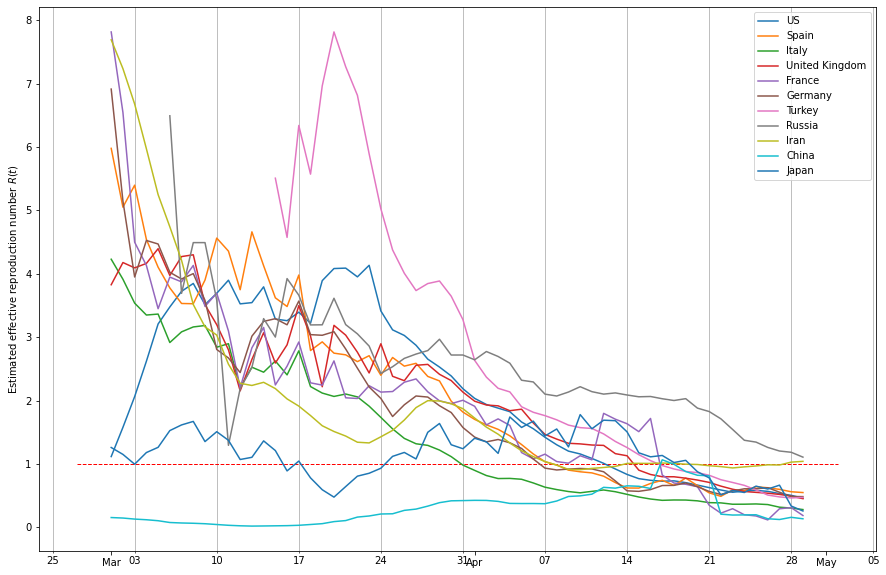

In [6]:
# Plot and save
fig, ax = plot_Rt(country_set, window=5)
fname=datetime.now().strftime('%y-%m-%d')+"-Rt_global"
fig.savefig(fname+'.png', dpi=80)
fig.savefig(fname+'.pdf')

# Prefecture-wise $R_{t}$ of Japan

[東京経済オンライン](https://toyokeizai.net/sp/visual/tko/covid19/)で整理されている[都道府県別感染状況](https://github.com/kaz-ogiwara/covid19/)から，各県の新規感染者数および実効再生産数$R_t$を下記の式で推計してプロット：
$$
R_t = \frac{\text{時点$t$の単位時間あたり新規感染者数}}{\text{時点$t$の感染力保持者数}}\times{\text{平均感染期間}}
$$
ただし，時点$t$の感染者保持者数は，時点$t$での陽性者数（感染者数）から，同時点の回復者数と死亡者数を引いたもの．

In [0]:
import matplotlib.pyplot as plt # グラフ描画
import matplotlib.dates as mdates # グラフ上の日付の取り扱い
import pandas as pd # データの取り扱い
import math # 数学関数全般
from datetime import datetime, timedelta # 時刻

# 県名および日本語-英語対応を取得
pref_set = "北海道,青森県,岩手県,宮城県,秋田県,山形県,福島県,茨城県,栃木県,群馬県,埼玉県,千葉県,東京都,神奈川県,新潟県,富山県,石川県,福井県,山梨県,長野県,岐阜県,静岡県,愛知県,三重県,滋賀県,京都府,大阪府,兵庫県,奈良県,和歌山県,鳥取県,島根県,岡山県,広島県,山口県,徳島県,香川県,愛媛県,高知県,福岡県,佐賀県,長崎県,熊本県,大分県,宮崎県,鹿児島県,沖縄県".split(',')
pref_jp2en_df = pd.read_csv('https://raw.githubusercontent.com/kalessin/japanese-address/master/japanese_address/data/prefs.dat', sep='\s+', header=None)
pref_jp2en = dict(zip(pref_jp2en_df.iloc[:,0], pref_jp2en_df.iloc[:,1]))
pref_en_set = [pref_jp2en[pref] for pref in pref_set]

# データフレームを読み込んで整形
orig_jp_df = pd.read_csv('https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/prefectures.csv', index_col="都道府県")
# 日本語になっている列名を振り直す
orig_jp_df.index = orig_jp_df.index.rename('pref')
orig_jp_df.columns = ["year", "month", "day", "confirmed", "hospitalized", "recovered", "death"]
# 年・月・日の列をまとめて date という列に置き換える
orig_date = [pd.Timestamp(**row[:3]) for i, row in orig_jp_df.iterrows()]
orig_jp_df["date"]= orig_date
orig_jp_df = orig_jp_df.set_index("date", append=True).iloc[:,3:]
# 各県のデータを共通の日付インデックスで整理し直す
first_date, last_date = orig_date[0], orig_date[-1]
date = pd.date_range(first_date, last_date)
def reform_pref_df(pref):
    df = orig_jp_df.loc[pref,:].reindex(date, fill_value=0)
    df.index = df.index.rename("date")
    df["pref"] = pref_jp2en[pref]
    df = df.set_index("pref", append=True)
    df = df.swaplevel("date", "pref")
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce', downcast='integer')
    df = df.fillna(0)
    return df
jp_df = pd.concat([reform_pref_df(pref) for pref in pref_set])


TypeError: ignored

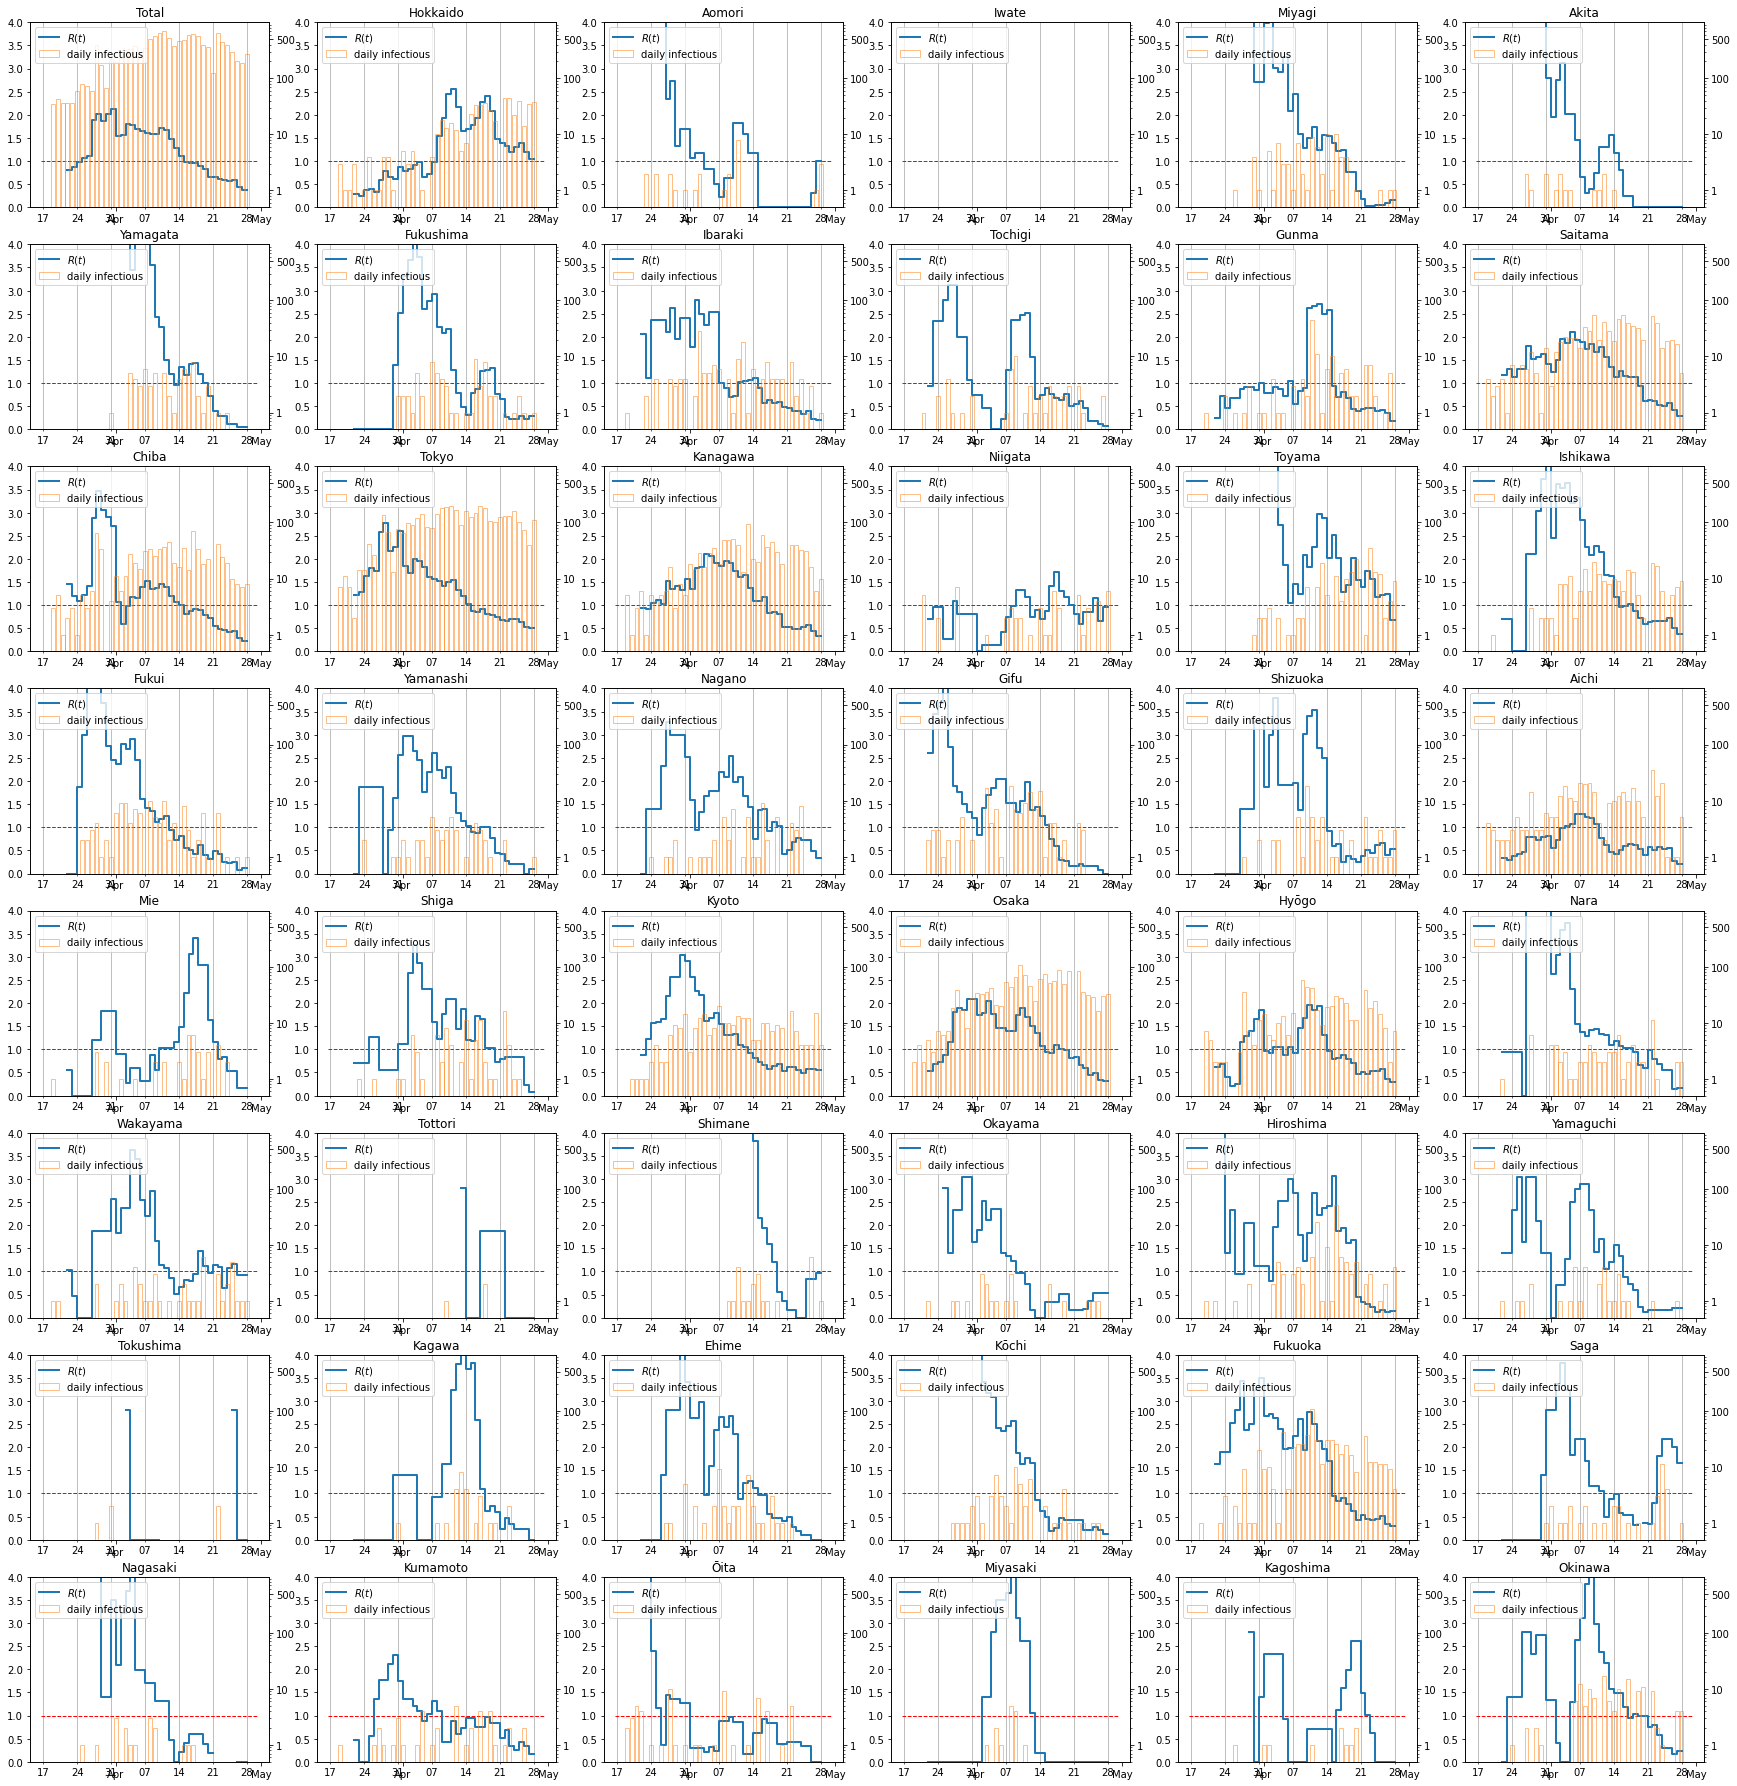

In [8]:
def plot_Rt_jp(prefs=pref_en_set, window=1, sp_cols = 6, total=True):
    D = 14 # 平均感染期間
    if total:
        prefs = ["Total"]+prefs
    sp_rows = math.ceil(len(pref_set) / sp_cols)
    fig = plt.figure(figsize=(5*sp_cols,4*sp_rows))
    for (pid, pref) in enumerate(prefs):
        if pref == "Total":
            pref_df = jp_df.sum(level="date")
        else:
            pref_df  = jp_df.loc[pref,:]
        confirmed = pref_df["confirmed"]
        recovered = pref_df["recovered"]
        death = pref_df["death"]
        I = confirmed - recovered - death
        j = confirmed.diff()
        Rt = j/I*D
        if window > 1:
          Rt = Rt.rolling(window).mean()
        Rt[Rt<0] = None
        j[j<1] = 1e-10
        ax1 = fig.add_subplot(sp_rows, sp_cols, pid+1)
        ax2 = ax1.twinx()
        ax1.plot(Rt, linewidth=2, label=u"$R(t)$", drawstyle="steps")
        ax2.bar(j.index, j, edgecolor="C1", facecolor='none', alpha=.5, label=u"daily infectious")
        # 見やすくなるように，x軸の大目盛を月ごと，小目盛を週ごとにする
        ax1.set_xticks(confirmed.index)
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax1.xaxis.set_minor_locator(mdates.WeekdayLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
        ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
        # R=1 の高さに点線を引く
        xlim = plt.xlim()
        ax1.hlines(1,xlim[0],xlim[1], linestyle='dashed', linewidth=1, color='r')
        ax1.set_ylim(0,4)
        ax1.grid(which='minor')
        ax2.set_yscale('log')
        ax2.set_ylim(.5,1e3)
        ax2.set_yticks([1,10,100,500])
        ax2.set_yticklabels([1, 10, 100, 500])
        #ax1.set_ylabel(r"Estimated effective reproduction number $R(t)$")
        handler1, label1 = ax1.get_legend_handles_labels()
        handler2, label2 = ax2.get_legend_handles_labels()
        plt.legend(handler1+handler2, label1+label2, loc=2)
        plt.title(pref)
    return fig
fig = plot_Rt_jp(window=5)
#fig = plot_Rt_jp(["Tokyo", "Miyagi"], window=2)

In [0]:
fname=datetime.now().strftime('%y-%m-%d')+"-Rt_jp"
fig.savefig(fname+'.png', dpi=80)
fig.savefig(fname+'.pdf')